# MLB Pitch Type Analysis

## Overview

## Business Problem

In [2]:
# import packages

import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

## Data Overview

In [3]:
# read in datasets

atbats = pd.read_csv('Data/atbats.csv')
pitches = pd.read_csv('Data/pitches.csv')
atbats19 = pd.read_csv('Data/2019_atbats.csv')
pitches19 = pd.read_csv('Data/2019_pitches.csv')

In [4]:
atbats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ab_id       740389 non-null  int64 
 1   batter_id   740389 non-null  int64 
 2   event       740389 non-null  object
 3   g_id        740389 non-null  int64 
 4   inning      740389 non-null  int64 
 5   o           740389 non-null  int64 
 6   p_score     740389 non-null  int64 
 7   p_throws    740389 non-null  object
 8   pitcher_id  740389 non-null  int64 
 9   stand       740389 non-null  object
 10  top         740389 non-null  bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [5]:
atbats19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185245 entries, 0 to 185244
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      185245 non-null  int64 
 1   top         185245 non-null  int64 
 2   ab_id       185245 non-null  int64 
 3   g_id        185245 non-null  int64 
 4   p_score     185245 non-null  int64 
 5   batter_id   185245 non-null  int64 
 6   pitcher_id  185245 non-null  int64 
 7   stand       185245 non-null  object
 8   p_throws    185245 non-null  object
 9   event       185245 non-null  object
 10  o           185245 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 15.5+ MB


In [6]:
# rearrange columns in atbats to match column order of atbats19

atbats = atbats[['inning', 'top', 'ab_id', 'g_id', 'p_score', 'batter_id', 'pitcher_id', 'stand', 'p_throws', 'event', 'o']]
atbats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740389 entries, 0 to 740388
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      740389 non-null  int64 
 1   top         740389 non-null  bool  
 2   ab_id       740389 non-null  int64 
 3   g_id        740389 non-null  int64 
 4   p_score     740389 non-null  int64 
 5   batter_id   740389 non-null  int64 
 6   pitcher_id  740389 non-null  int64 
 7   stand       740389 non-null  object
 8   p_throws    740389 non-null  object
 9   event       740389 non-null  object
 10  o           740389 non-null  int64 
dtypes: bool(1), int64(7), object(3)
memory usage: 57.2+ MB


In [7]:
# concatenate the two atbats Dataframes

atbats_all = pd.concat([atbats, atbats19], ignore_index=True, sort=False)
atbats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925634 entries, 0 to 925633
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      925634 non-null  int64 
 1   top         925634 non-null  int64 
 2   ab_id       925634 non-null  int64 
 3   g_id        925634 non-null  int64 
 4   p_score     925634 non-null  int64 
 5   batter_id   925634 non-null  int64 
 6   pitcher_id  925634 non-null  int64 
 7   stand       925634 non-null  object
 8   p_throws    925634 non-null  object
 9   event       925634 non-null  object
 10  o           925634 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 77.7+ MB


In [8]:
# drop columns in atbats_all DataFrame that aren't useful

atbats_all = atbats_all.drop(['top', 'p_score', 'o'], axis=1)

In [9]:
# rename some columns in pitches to match those that I renamed in the pitches19 csz before importing

pitches.rename(columns = {'px': 'horiz_loc', 'pz': 'vert_loc', 'pfx_x': 'horiz_move', 'pfx_z': 'vert_move'}, inplace=True)

In [10]:
# concatenate the two pitches Dataframes

pitches_all = pd.concat([pitches, pitches19], ignore_index=True, sort=False)
pitches_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595944 entries, 0 to 3595943
Data columns (total 40 columns):
 #   Column           Dtype  
---  ------           -----  
 0   horiz_loc        float64
 1   vert_loc         float64
 2   start_speed      float64
 3   end_speed        float64
 4   spin_rate        object 
 5   spin_dir         object 
 6   break_angle      float64
 7   break_length     float64
 8   break_y          float64
 9   ax               float64
 10  ay               float64
 11  az               float64
 12  sz_bot           float64
 13  sz_top           float64
 14  type_confidence  object 
 15  vx0              float64
 16  vy0              float64
 17  vz0              float64
 18  x                object 
 19  x0               float64
 20  y                object 
 21  y0               float64
 22  z0               float64
 23  horiz_move       float64
 24  vert_move        float64
 25  nasty            float64
 26  zone             object 
 27  code        

In [11]:
# drop columns in pitches_all DataFrame that aren't useful

pitches_all = pitches_all.drop(['ax', 'ay', 'az', 'sz_bot', 'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 
              'x', 'x0', 'y', 'y0', 'z0', 'horiz_move', 'vert_move', 'nasty', 'zone',
              'code', 'type', 'event_num', 'b_score'], axis=1)

The DataFrames with the data on pitches contained every pitch in every at bat, but I only need the final pitch that resulted in a play.  Therefore, I'll drop the pitches in each at bat that didn't end the at bat.

In [12]:
# drop duplicates of ab_id in pitches_all, keeping only the last entry for each

pitches_all = pitches_all.drop_duplicates('ab_id', keep='last')
pitches_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925461 entries, 5 to 3595943
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   horiz_loc     919761 non-null  float64
 1   vert_loc      919761 non-null  float64
 2   start_speed   919786 non-null  float64
 3   end_speed     919786 non-null  float64
 4   spin_rate     919761 non-null  object 
 5   spin_dir      919761 non-null  object 
 6   break_angle   919761 non-null  float64
 7   break_length  919761 non-null  float64
 8   break_y       919761 non-null  float64
 9   pitch_type    919761 non-null  object 
 10  ab_id         925461 non-null  float64
 11  b_count       925461 non-null  float64
 12  s_count       925461 non-null  float64
 13  outs          925461 non-null  float64
 14  pitch_num     925461 non-null  float64
 15  on_1b         925461 non-null  float64
 16  on_2b         925461 non-null  float64
 17  on_3b         925461 non-null  float64
dtypes: 

Next, I need to merge the two DataFrames (atbats_all and pitches_all) on the ab_id column.

In [13]:
# change ab_id in atbats_all from integers to strings

atbats_all['ab_id'] = atbats_all['ab_id'].astype(str)
atbats_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925634 entries, 0 to 925633
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   inning      925634 non-null  int64 
 1   ab_id       925634 non-null  object
 2   g_id        925634 non-null  int64 
 3   batter_id   925634 non-null  int64 
 4   pitcher_id  925634 non-null  int64 
 5   stand       925634 non-null  object
 6   p_throws    925634 non-null  object
 7   event       925634 non-null  object
dtypes: int64(4), object(4)
memory usage: 56.5+ MB


In [14]:
# change ab_id in pitches_all from floats to strings

pitches_all['ab_id'] = pitches_all['ab_id'].astype(str)

In [15]:
# remove the decimal in ab_id of pitches_all to match the ab_id of atbats_all

pitches_all['ab_id'] = pitches_all['ab_id'].str[:-2]

In [16]:
df = atbats_all.merge(pitches_all, on='ab_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 925461 entries, 0 to 925460
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   inning        925461 non-null  int64  
 1   ab_id         925461 non-null  object 
 2   g_id          925461 non-null  int64  
 3   batter_id     925461 non-null  int64  
 4   pitcher_id    925461 non-null  int64  
 5   stand         925461 non-null  object 
 6   p_throws      925461 non-null  object 
 7   event         925461 non-null  object 
 8   horiz_loc     919761 non-null  float64
 9   vert_loc      919761 non-null  float64
 10  start_speed   919786 non-null  float64
 11  end_speed     919786 non-null  float64
 12  spin_rate     919761 non-null  object 
 13  spin_dir      919761 non-null  object 
 14  break_angle   919761 non-null  float64
 15  break_length  919761 non-null  float64
 16  break_y       919761 non-null  float64
 17  pitch_type    919761 non-null  object 
 18  b_co

In [17]:
# sanity check

df.head()

,inning,ab_id,g_id,batter_id,pitcher_id,stand,p_throws,event,horiz_loc,vert_loc,...,break_length,break_y,pitch_type,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,1,2015000001,201500001,572761,452657,L,L,Groundout,0.627,2.397,...,3.7,23.7,FF,2.0,2.0,0.0,6.0,0.0,0.0,0.0
1,1,2015000002,201500001,518792,452657,L,L,Double,-0.257,2.047,...,4.8,23.8,FC,1.0,0.0,1.0,2.0,0.0,0.0,0.0
2,1,2015000003,201500001,407812,452657,R,L,Single,-0.286,1.830,...,4.8,23.7,FF,2.0,0.0,1.0,3.0,0.0,1.0,0.0
3,1,2015000004,201500001,425509,452657,R,L,Strikeout,-0.711,1.971,...,11.0,23.9,CU,0.0,2.0,1.0,3.0,1.0,0.0,0.0
4,1,2015000005,201500001,571431,452657,L,L,Strikeout,-1.681,0.875,...,5.8,23.8,FC,1.0,2.0,2.0,5.0,1.0,0.0,0.0


In [18]:
df['pitch_type'].isna().sum()

5700

In [19]:
df = df[df['pitch_type'].notna()]

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919761 entries, 0 to 925460
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   inning        919761 non-null  int64  
 1   ab_id         919761 non-null  object 
 2   g_id          919761 non-null  int64  
 3   batter_id     919761 non-null  int64  
 4   pitcher_id    919761 non-null  int64  
 5   stand         919761 non-null  object 
 6   p_throws      919761 non-null  object 
 7   event         919761 non-null  object 
 8   horiz_loc     919761 non-null  float64
 9   vert_loc      919761 non-null  float64
 10  start_speed   919761 non-null  float64
 11  end_speed     919761 non-null  float64
 12  spin_rate     919761 non-null  object 
 13  spin_dir      919761 non-null  object 
 14  break_angle   919761 non-null  float64
 15  break_length  919761 non-null  float64
 16  break_y       919761 non-null  float64
 17  pitch_type    919761 non-null  object 
 18  b_co

In [21]:
df['pitch_type'].value_counts(normalize=True)

FF    0.339439
SL    0.165928
FT    0.119097
CH    0.111533
SI    0.087041
CU    0.076297
FC    0.056403
KC    0.021557
FS    0.016869
KN    0.003280
IN    0.001911
EP    0.000292
FO    0.000273
SC    0.000035
PO    0.000034
UN    0.000008
FA    0.000002
AB    0.000001
Name: pitch_type, dtype: float64

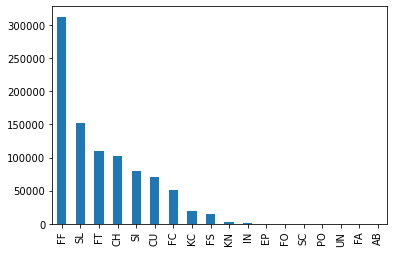

In [22]:
df['pitch_type'].value_counts().plot(kind='bar')
plt.show()

I'm not interested in any pitches accounting for less than 1% of the total...except for knuckleballs because I'm curious about them.  I'll only look at the top 10 most frequent pitch types.

In [23]:
# create a list of the top 10 most used pitches

pitch_type_keep = ['FF', 'SL', 'FT', 'CH', 'SI', 'CU', 'FC', 'KC', 'FS', 'KN']

In [24]:
df = df[df['pitch_type'].isin(pitch_type_keep)]

In [25]:
df['pitch_type'].value_counts(normalize=True)

FF    0.340309
SL    0.166353
FT    0.119402
CH    0.111819
SI    0.087264
CU    0.076493
FC    0.056547
KC    0.021612
FS    0.016912
KN    0.003289
Name: pitch_type, dtype: float64

The dependent variable is the outcome of the at bat, which is provided in the event column.

In [26]:
df['event'].value_counts()

Strikeout                       198566
Groundout                       166152
Single                          134005
Flyout                          100115
Walk                             71648
Lineout                          55759
Pop Out                          42949
Double                           41433
Home Run                         28817
Forceout                         18590
Grounded Into DP                 18076
Hit By Pitch                      8861
Field Error                       7705
Sac Fly                           5880
Sac Bunt                          4702
Triple                            4220
Double Play                       2201
Runner Out                        1598
Fielders Choice Out               1530
Bunt Groundout                    1473
Fielders Choice                    800
Bunt Pop Out                       679
Strikeout - DP                     576
Batter Interference                209
Catcher Interference               208
Caught Stealing 2B       

I want to focus on outcomes that are related directly to an at bat's final pitch, but there are some events given that can be considered unrelated to the specific pitch.  Those rows, therefore, can be removed.  Looking at the list, I'm also going to remove the events that were documented fewer than 10 times.  Some of these are not very clear, and they don't add enough weight to the problem anyway.

In [27]:
# create a list of events that aren't affected by the pitch

drop_events = ['Batter Interference', 'Catcher Interference', 'Caught Stealing 2B',
               'Pickoff Caught Stealing 2B', 'Fan Interference', 'Pickoff 1B',
               'Caught Stealing Home', 'Caught Stealing 3B', 'Pickoff 2B',
               'Sacrifice Bunt DP', 'Wild Pitch', 'Pickoff Caught Stealing Home',
               'Pickoff 3B', 'Runner Double Play', 'Sac Bunt Double Play',
               'Game Advisory', 'Intent Walk', 'Pickoff Caught Stealing 3B',
               'Passed Ball', 'Stolen Base 2B', 'Pickoff Error 1B']

In [28]:
# drop rows with events in drop_events

df = df.drop(df[df['event'].isin(drop_events)].index)

In [29]:
df['event'].value_counts()

Strikeout                198566
Groundout                166152
Single                   134005
Flyout                   100115
Walk                      71648
Lineout                   55759
Pop Out                   42949
Double                    41433
Home Run                  28817
Forceout                  18590
Grounded Into DP          18076
Hit By Pitch               8861
Field Error                7705
Sac Fly                    5880
Sac Bunt                   4702
Triple                     4220
Double Play                2201
Runner Out                 1598
Fielders Choice Out        1530
Bunt Groundout             1473
Fielders Choice             800
Bunt Pop Out                679
Strikeout - DP              576
Strikeout Double Play       146
Sac Fly DP                   76
Bunt Lineout                 61
Triple Play                  23
Sac Fly Double Play          11
Name: event, dtype: int64

The pitcher's goal is to get outs, so I'll break down the event variable into those that result in outs and those that don't.  One exception is the 'Field Error' event, which I will identify as an out result since the only reason an out wasn't recorded (according to the official scorer) in such an event was the defense of the pitcher's team and no the pitch itself.  The result of the pitch should have been an out.

In [30]:
# create a list of events that do not result in an out

no_out = ['Single', 'Walk', 'Double', 'Home Run', 'Hit By Pitch', 'Triple']

In [31]:
# create numerical categories for out or no out

def out_made(event):
    if event in no_out:
        return 0
    else:
        return 1

In [32]:
# add new column

df['out_made'] = df['event'].apply(out_made)

df['out_made'].value_counts(normalize=True)

1    0.68474
0    0.31526
Name: out_made, dtype: float64

For the top ten most frequent pitch types, how do they rank in terms of getting outs?  If out_made = 1  is an out and out_made = 0 is an event without an out, the higher the mean of those values, the more often the pitch leads to an out.

In [33]:
pitch_success = df.groupby("pitch_type")["out_made"].mean().sort_values(ascending = False)

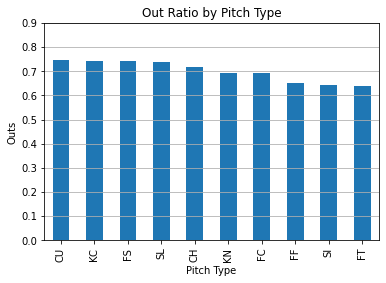

In [34]:
# plot the pitch types in order of their ratios of events with outs vs no outs

pitch_success.plot(kind = "bar")
plt.xlabel("Pitch Type")
plt.ylabel("Outs")
plt.title("Out Ratio by Pitch Type")
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(axis = 'y')
plt.show()

In [35]:
df.groupby('pitch_type').out_made.value_counts(normalize=True)

pitch_type  out_made
CH          1           0.715979
            0           0.284021
CU          1           0.745539
            0           0.254461
FC          1           0.691983
            0           0.308017
FF          1           0.652794
            0           0.347206
FS          1           0.742518
            0           0.257482
FT          1           0.638863
            0           0.361137
KC          1           0.744310
            0           0.255690
KN          1           0.694067
            0           0.305933
SI          1           0.641827
            0           0.358173
SL          1           0.740322
            0           0.259678
Name: out_made, dtype: float64

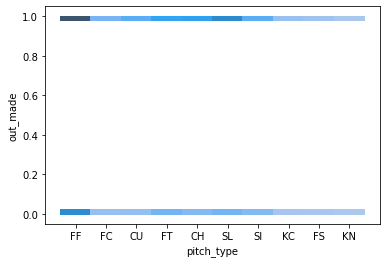

In [36]:
sns.histplot(x=df['pitch_type'], y=df['out_made']);

In [48]:
event_by_pitch_type = pd.crosstab(df['pitch_type'], df['out_made'], normalize = 'columns')
event_by_pitch_type

out_made,0,1
pitch_type,,
CH,0.100736,0.116917
CU,0.061737,0.083280
FC,0.055238,0.057135
FF,0.374796,0.324434
FS,0.013814,0.018341
FT,0.136772,0.111398
KC,0.017534,0.023500
KN,0.003194,0.003336
SI,0.099161,0.081811


<AxesSubplot:xlabel='count', ylabel='pitch_type'>

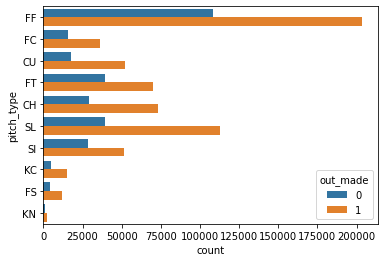

In [53]:
# Create a count plot

sns.countplot(data=df, y = "pitch_type", hue="out_made")
#ax.legend(['No Out', 'Out'])
#ax.set_title('Number of Mentions of Products in Tweets')

#plt.show()

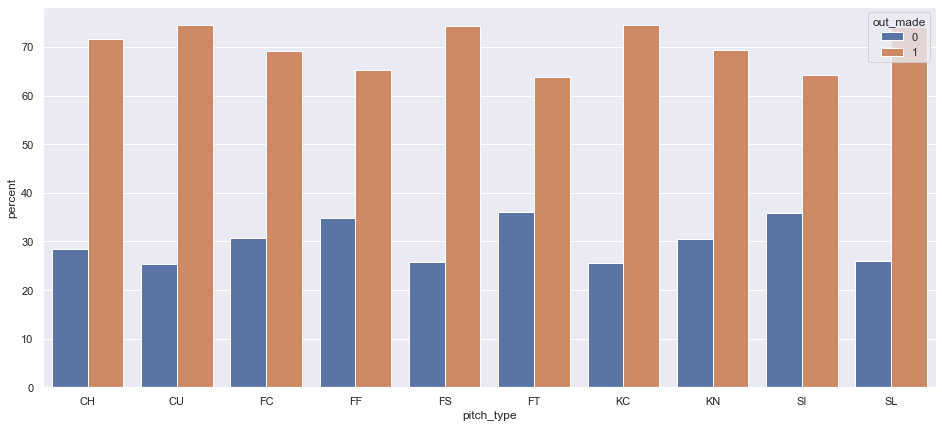

In [85]:
#sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(16, 7))

x = 'pitch_type'
y = 'out_made'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.barplot,'data'), ax=ax,x=x,y='percent',hue=y));

## Modeling

The baseline model is a dummy classifier with pitch type as the only x variable.

In [42]:
# define X and y and perform train test split with 20% in test set

X = df['pitch_type']
y = df['out_made']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [43]:
# instantiate and fit the model on train set

base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [45]:
y_pred = base_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6845759855125428

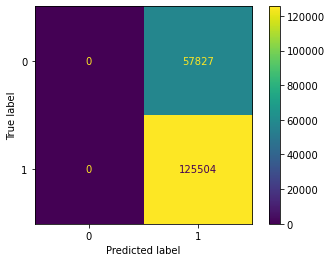

In [46]:
cm = confusion_matrix(y_test, y_pred, labels=base_model.classes_)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_model.classes_)
cm_disp.plot()
plt.show()

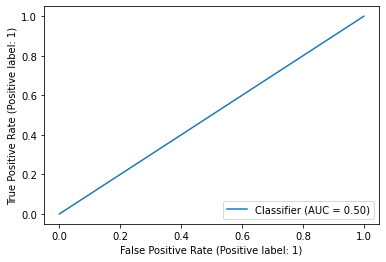

In [47]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()